In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

data = pd.read_csv('48fcb848-220c-4af0-839b-4fd8ac812c0f', low_memory=False)

month_dict = {'Enero':1,
             'Febrero':2,
             'Marzo':3,
             'Abril':4,
             'Mayo':5,
             'Junio':6,
             'Julio':7,
             'Agosto':8,
             'Septiembre':9,
             'Octubre':10,
             'Noviembre':11,
             'Diciembre':12}

# Datos Abiertos CDMX

### Calidad de datos

Para indetificar la calidad de los datos haría las siguientes pruebas:
1. Conteo de valores faltantes y nulos
2. Tipo de dato (int, char, dbl, date, ...)
3. Valores imposibles

**Variables Categoricas**
1. Número de categorias
2. Conteos por categoria
3. Proporciones por categoría
4. Errores de ortografía

**Variables numéricas**
1. Distribución
2. Cuantiles
3. Máximo y mínimo
4. Media, mediana, desviación 
5. Correlaciones

### Delitos registrados en la tabla

In [2]:
# Numero de registros
print("Numero de registros", len(data._id))

print("Fecha primer registro: ",)

Numero de registros 1168500
Fecha primer registro: 


### Rango de tiempo de los registros
* En la variable `ao_hechos` se registran delitos que ocurrieron desde 1906, la mayor parte de ellos fue después del año 2000.
* En la variable `ao_inicio` se registra la fecha en que se abre la carpeta de investigación. Tiene registros desde 2016 a 2021

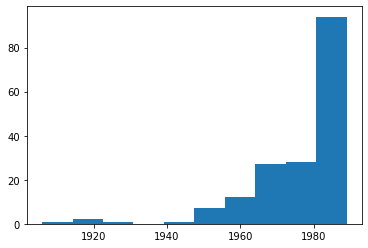

In [3]:
# Tiene registro de delitos en varios año, el mas viejo es de 1906
# Solo se muestran los delitos anteriores a 1990

plt.hist(data.loc[data.ao_hechos<1990].ao_hechos)
plt.show()

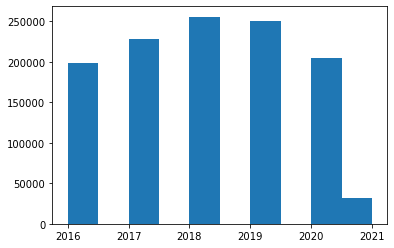

In [4]:
# Comprede carpetas que se abrieron desde 2016 hasta la fecha

plt.hist(data.ao_inicio)
plt.show()

### Distribución del número de delitos


In [5]:
delitos_dist = data[["delito", "_id"]].groupby(['delito']).count().sort_values(by = '_id', ascending =False).rename(columns={"_id":'counts'})
total =sum(delitos_dist.counts)
delitos_dist['percent'] = delitos_dist.counts / total
delitos_dist['cumulative'] = np.cumsum(delitos_dist.percent)
delitos_dist['id'] = np.arange(1,len(delitos_dist.percent)+1)

In [6]:
# los 5 delitos mas frecuentes.
# Representan el 32.7% de todos los delitos

delitos_dist[0:5]

,counts,percent,cumulative,id
delito,,,,
VIOLENCIA FAMILIAR,116335,0.099559,0.099559,1
FRAUDE,70603,0.060422,0.159981,2
ROBO DE OBJETOS,68950,0.059007,0.218988,3
ROBO A NEGOCIO SIN VIOLENCIA,65379,0.055951,0.274940,4
AMENAZAS,61256,0.052423,0.327362,5


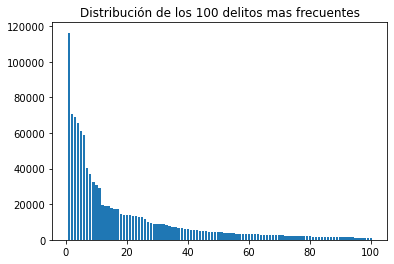

In [9]:
# Distribución de delitos
num_elements = 100

plt.bar(delitos_dist.id[0:num_elements], delitos_dist.counts[0:num_elements])
plt.title(f"Distribución de los {num_elements} delitos mas frecuentes")
plt.show()

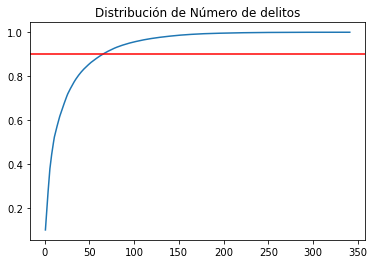

In [8]:
# qq plot del numero de delitos

plt.plot(delitos_dist.id, delitos_dist.cumulative)
plt.axhline(y=0.9, color='r', linestyle='-')
plt.title("Distribución de Número de delitos")
plt.show()

In [104]:
# 
limit = 0.9

print(f"En total hay {delitos_dist.id.max()} distintos delitos registrados")
print(f"El {limit*100}% de los delitos se concetran en {delitos_dist.loc[delitos_dist.cumulative <= limit].id.max()} distintos delitos")

En total hay 341 distintos delitos registrados
El 90.0% de los delitos se concetran en 65 distintos delitos


### Delitos en aumento

Para determinar los delitos que van en aumento vamos a usar la siguiente lógica:
1. Se determina el promedio mensual de delitos del mes anterior
2. Se calculan los delitos en los meses de este año
3. Se calcula una tasa de crecimiento
4. Si la tasa de crecimiento de enero y febrero es positiva y mayor a un `limite` se entiende como delito en aumento, de manera similar se determinan los que van bajando

In [10]:
# promdeio mensual de delitos en 2020
ave_2020 = data[["delito", "_id"]].loc[data.ao_hechos == 2020].groupby(["delito"])["_id"].count().reset_index(drop=False).rename(columns={"_id":'counts'})
ave_2020["ave_2020"] =ave_2020["counts"]/12

# Delitos en los dos meses que se tienen de 2021
# enero
delitos_2021 = data[["delito", "_id", 'ao_hechos', 'mes_hechos']].loc[(data.ao_hechos > 2020) & (data.mes_hechos=='Enero')]
ene_2021 = delitos_2021.groupby(["delito"])["_id"].count().reset_index(drop =False).rename(columns={"_id":'ene'})

# febrero
delitos_2021 = data[["delito", "_id", 'ao_hechos', 'mes_hechos']].loc[(data.ao_hechos > 2020) & (data.mes_hechos=='Febrero')]
feb_2021 = delitos_2021.groupby(["delito"])["_id"].count().reset_index(drop =False).rename(columns={"_id":'feb'})

# joid dfs
historia_delitos = ave_2020[["delito","ave_2020"]].merge(ene_2021, how = 'outer', on='delito').merge(feb_2021, how = 'outer', on='delito')

# clasificaremos a la alza los delitos que aumentaron en mas de x% en los meses consecutivos
historia_delitos.sort_values(by='ave_2020', ascending=False)
historia_delitos["gr_ene"] = historia_delitos.ene/historia_delitos.ave_2020 -1
historia_delitos["gr_feb"] = historia_delitos.feb/historia_delitos.ene -1

In [12]:
treshold =.05
min_ocurrances = 10

delitos_alza = historia_delitos.loc[(historia_delitos.gr_ene > treshold) &
                                   (historia_delitos.gr_feb > treshold) &
                                   (historia_delitos.feb > min_ocurrances)]

print("Delitos a la alza según los límites seleccionados")
delitos_alza

Delitos a la alza según los límites seleccionados


,delito,ave_2020,ene,feb,gr_ene,gr_feb
87,HOMICIDIO CULPOSO POR TRÁNSITO VEHICULAR (COLI...,24.250000,26.0,33.0,0.072165,0.269231
153,RETENCIÓN DE MENORES,6.166667,11.0,17.0,0.783784,0.545455
201,ROBO A TRANSEUNTE A BORDO DE TAXI PÚBLICO Y PR...,12.666667,16.0,19.0,0.263158,0.187500
205,ROBO A TRANSEUNTE EN NEGOCIO CON VIOLENCIA,39.666667,46.0,49.0,0.159664,0.065217


In [13]:
treshold =.1
min_ocurrances = 100

delitos_baja = historia_delitos.loc[(historia_delitos.gr_ene < -treshold) &
                                   (historia_delitos.gr_feb < -treshold) &
                                   (historia_delitos.feb > min_ocurrances)]

print("Delitos a la baja según los límites seleccionados")
delitos_baja

Delitos a la baja según los límites seleccionados


,delito,ave_2020,ene,feb,gr_ene,gr_feb
7,AMENAZAS,1182.666667,1052.0,912.0,-0.110485,-0.133080
26,DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...,216.833333,194.0,170.0,-0.105304,-0.123711
54,DESPOJO,308.333333,257.0,191.0,-0.166486,-0.256809
76,FRAUDE,995.916667,837.0,577.0,-0.159568,-0.310633
156,ROBO A CASA HABITACION SIN VIOLENCIA,286.083333,244.0,188.0,-0.147102,-0.229508
230,ROBO DE OBJETOS,741.083333,593.0,474.0,-0.199820,-0.200675
240,ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...,428.750000,350.0,300.0,-0.183673,-0.142857


### Alcadias con mas y menos delitos
La alcaldía con más delitos es **CUAUHTEMOC**  
La lista de alcaldías con menos delitos se muestra más adeltante. Si limitamos las alcaldias a CDMX encontramos que la que tiene menos delitos es **Milpa Alta**

In [15]:
df_cuentas_alcaldias = data[["alcaldia_hechos","_id"]].groupby(["alcaldia_hechos"]).count().sort_values(by = '_id', ascending =False).rename(columns={"_id":'counts'})

In [16]:
df_cuentas_alcaldias.loc[df_cuentas_alcaldias.counts.idxmax()]

counts    182776
Name: CUAUHTEMOC, dtype: int64

In [21]:
# Alcaldías con menos delitos
print("Alcaldias con menos delitos")
pd.DataFrame(df_cuentas_alcaldias.loc[df_cuentas_alcaldias.counts ==1].index)

Alcaldias con menos delitos


,alcaldia_hechos
0,COYUCA DE BENITEZ
1,COSAMALOAPAN DE CARPIO
2,COYUCA DE CATALAN
3,TEMOAYA
4,TIERRA BLANCA
...,...
224,SAN MIGUEL TOTOLAPAN
225,SAN MIGUEL XOXTLA
226,FRANCISCO I. MADERO
227,SAN PABLO DEL MONTE


In [22]:
df_cuentas_alcaldias[0:16]

,counts
alcaldia_hechos,
CUAUHTEMOC,182776
IZTAPALAPA,175762
GUSTAVO A MADERO,117099
BENITO JUAREZ,97762
ALVARO OBREGON,78968
COYOACAN,77889
MIGUEL HIDALGO,76304
TLALPAN,68332
VENUSTIANO CARRANZA,67384


In [26]:
df_cuentas_alcaldias.columns

Index(['counts'], dtype='object')

In [29]:
alcaldias_cdmx = df_cuentas_alcaldias[0:16].index

### Colonias con mas delitos
Las tres colonias con más delitos se presentan a continuación

In [30]:
df_cuentas_colonia = data[["alcaldia_hechos","colonia_hechos","_id"]].groupby(["alcaldia_hechos","colonia_hechos",]).count().reset_index(drop=False)

df_cuentas_colonia = df_cuentas_colonia.groupby(["alcaldia_hechos"]).apply(lambda x: x.nlargest(3,columns=['_id'])).reset_index(drop=True)

In [33]:
df_cuentas_colonia.loc[df_cuentas_colonia.alcaldia_hechos.isin(alcaldias_cdmx)]

,alcaldia_hechos,colonia_hechos,_id
0,ALVARO OBREGON,JARDINES DEL PEDREGAL,3554
1,ALVARO OBREGON,SAN ANGEL,2778
2,ALVARO OBREGON,ZEDEC SANTA FE,2695
3,AZCAPOTZALCO,EL ROSARIO,4040
4,AZCAPOTZALCO,INDUSTRIAL VALLEJO,2631
5,AZCAPOTZALCO,CENTRO DE AZCAPOTZALCO,2463
6,BENITO JUAREZ,DEL VALLE CENTRO,17144
7,BENITO JUAREZ,NARVARTE,12518
8,BENITO JUAREZ,PORTALES SUR,6466
9,COYOACAN,PEDREGAL DE SANTO DOMINGO,6818


### Estacionalidad
Usando la funcion `seasonal_decompose` del paquete stats model podemos notar que el total de delitos si sigue una componente estacional por periodo.

In [45]:
# Add date variables
cuentas= data[["ao_hechos", "mes_hechos", "fecha_hechos", "_id"]]
cuentas["date"]=pd.to_datetime(cuentas.fecha_hechos, format = "%Y/%m/%d")
cuentas["mes"] = cuentas.mes_hechos.map(month_dict)

# Agregate by month, year
por_mes=cuentas.groupby(["mes_hechos", "mes", "ao_hechos"])["_id"].count().reset_index(drop=False).rename(columns={"_id":'counts'})

# select recent years
delitos_recientes =  por_mes.loc[por_mes.ao_hechos > 2016]

C:\Users\jphm1\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jphm1\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [55]:
delitos_recientes=delitos_recientes.sort_values(by=["ao_hechos", "mes"]).reset_index(drop=True)

In [62]:
delitos_recientes.head()

,mes_hechos,mes,ao_hechos,counts
0,Enero,1.0,2017.0,17591
1,Febrero,2.0,2017.0,16471
2,Marzo,3.0,2017.0,18651
3,Abril,4.0,2017.0,17235
4,Mayo,5.0,2017.0,19731


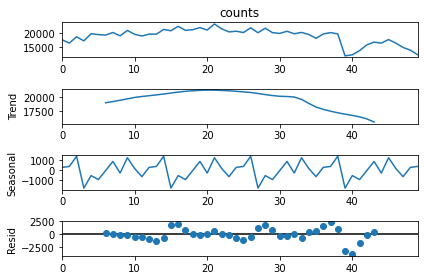

In [59]:
res = seasonal_decompose(delitos_recientes.counts, model='additive', period=12).plot()

### Delitos mas caracteristicos de cada alcaldía
Se calcula un score tomando en cuenta la frecuencia total de cada delito y la frecuencia dentro de su alcaldía. 
Se puede ajustar con el parametro `peso_delito` que es un multiplicador para castigar los delitos más comunes.

La formula es como sigue:
$$Score = \frac{n_{del x alc}}{n_{alc}} - w \frac{n_{delito}}{N} $$

In [73]:
data_cdmx =  data.loc[data.alcaldia_hechos.isin(alcaldias_cdmx)]

In [119]:
peso_delito =2

# Calcula delitos por alcaldia
delitos_alcaldia = data_cdmx[["alcaldia_hechos","delito","_id"]].groupby(["alcaldia_hechos","delito",]).count().reset_index(drop=False).rename(columns={"_id":'counts'})

# Calcula el total alcaldia
alcaldia= data_cdmx[["alcaldia_hechos","_id"]].groupby(["alcaldia_hechos",]).count().reset_index(drop=False).rename(columns={"_id":'total_alcaldia'})

#unimos los df
delitos_alcaldia = delitos_alcaldia.merge(alcaldia, how = 'left', on='alcaldia_hechos')
delitos_alcaldia["tasa_delito_alcaldia"] = delitos_alcaldia.counts / delitos_alcaldia.total_alcaldia

# calcula total de delitos
delitos= data_cdmx[["delito","_id"]].groupby(["delito",]).count().reset_index(drop=False).rename(columns={"_id":'counts'})
total = sum(delitos.counts)
delitos["tasa_delito"] = peso_delito * delitos.counts / total

# Unimos los delitos con las alcaldias
delitos_alcaldia = delitos_alcaldia.merge(delitos, how = 'left', on='delito')
delitos_alcaldia["score"] = delitos_alcaldia.tasa_delito_alcaldia - delitos_alcaldia.tasa_delito

In [120]:
frec_delitos = delitos_alcaldia[["delito","alcaldia_hechos", "score"]].groupby(["alcaldia_hechos"]).apply(lambda x: x.nlargest(1,columns=['score']))

In [121]:
frec_delitos

,,delito,alcaldia_hechos,score
alcaldia_hechos,,,,
ALVARO OBREGON,176,ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VI...,ALVARO OBREGON,0.009998
AZCAPOTZALCO,485,ROBO A TRANSEUNTE EN PARQUES Y MERCADOS CON VI...,AZCAPOTZALCO,0.005666
BENITO JUAREZ,773,ROBO DE ACCESORIOS DE AUTO,BENITO JUAREZ,0.017339
COYOACAN,999,ROBO A NEGOCIO SIN VIOLENCIA POR FARDEROS (TIE...,COYOACAN,0.000238
CUAJIMALPA DE MORELOS,1151,DELITOS AMBIENTALES,CUAJIMALPA DE MORELOS,0.003628
CUAUHTEMOC,1546,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,CUAUHTEMOC,0.011088
GUSTAVO A MADERO,1910,ROBO DE VEHICULO DE SERVICIO PÚBLICO CON VIOLE...,GUSTAVO A MADERO,0.000477
IZTACALCO,2117,ROBO A PASAJERO A BORDO DE PESERO COLECTIVO CO...,IZTACALCO,0.003180
IZTAPALAPA,2492,TORTURA,IZTAPALAPA,0.002050


In [123]:
delitos.sort_values(by="tasa_delito", ascending = False).head(10)

,delito,counts,tasa_delito
339,VIOLENCIA FAMILIAR,115369,0.199508
96,FRAUDE,69861,0.120811
277,ROBO DE OBJETOS,68540,0.118527
201,ROBO A NEGOCIO SIN VIOLENCIA,65344,0.113000
10,AMENAZAS,61066,0.105602
256,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,58750,0.101597
59,DENUNCIA DE HECHOS,39334,0.068020
263,ROBO DE ACCESORIOS DE AUTO,36809,0.063654
279,ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO,32170,0.055632
287,ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...,30210,0.052242


### Homicidos Dolosos por cada 100k habitantes
Datos de población tomados de http://cuentame.inegi.org.mx/monografias/informacion/df/poblacion/default.aspx?tema=me&e=09


In [137]:
poblacion = [545884, 1835486, 1173351, 434153, 759137, 614447, 414470, 699928, 443704,
 432205, 404695, 442178, 396313, 247622, 217686, 152685]


poblacion = pd.DataFrame({'alcaldia_hechos':alcaldias_cdmx, 'poblacion':poblacion})

In [167]:
# extrae data de homicidios por año
homicidio = data_cdmx.loc[data_cdmx.categoria_delito.str.contains("HOMICIDIO DOLOSO")]
homicidio = homicidio.groupby(["ao_hechos", "alcaldia_hechos"])["_id"].count().reset_index(drop =False).rename(columns={"_id":'counts'})

# une con df de poblacion
homicidio = homicidio.merge(poblacion, on="alcaldia_hechos", how='left')

In [177]:
homicidio["tasa"] = homicidio.counts * 100000 / homicidio.poblacion
homicidio.loc[homicidio.ao_hechos > 2015].sort_values(by=["alcaldia_hechos", "ao_hechos"]).pivot(index="alcaldia_hechos", values = "tasa", columns="ao_hechos")

ao_hechos,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
alcaldia_hechos,,,,,,
ALVARO OBREGON,8.298897,12.909396,12.514210,16.992980,9.089268,1.185557
AZCAPOTZALCO,7.172522,9.486239,12.956814,11.337213,11.568584,1.156858
BENITO JUAREZ,6.219006,5.297672,4.837004,4.837004,5.528005,0.691001
COYOACAN,5.533431,7.160911,7.649154,9.764878,7.323659,0.976488
CUAJIMALPA DE MORELOS,3.215641,3.675018,7.350036,5.971904,5.053150,0.918755
CUAUHTEMOC,18.135721,20.883558,25.096907,22.165881,20.700369,3.297404
GUSTAVO A MADERO,13.124802,18.323588,21.988305,19.431526,14.573644,2.045424
IZTACALCO,9.142688,8.401389,13.343382,10.378186,14.578880,1.976797
IZTAPALAPA,12.476260,12.966593,17.434075,18.687149,14.328630,1.961333


### Indicador de nivel de inseguridad
Para diseñar un indicador de nivel de inseguridad.

Por la estructura que ya tengo manejada en los datos lo hago a nivel alcaldía de la CDMX. Sin embargo se puede extrapolar a todos los muncicios u otras regiones geográficas del país en que tengamos los datos de población y delitos.

Lo que incluye mi indicador son las siguientes variables:
* Aumento en delitos en el último año - indica tendencias
* Población - en áreas con mayor población se esperan mas delitos
* Categorización de gravedad de delito - Es más inseguro conforme los delitos son mas graves

La relación entre ellas sería de una manera:

$$Tasa_{delito} = \sum_{delito} \frac{(1 + \% aumento) * gravedad * n_{delito} }{población}$$


### Patrones de concentración

### Rutas donde ocurren mas delitos